In [1]:
#for data aggregation
import numpy as np
import pandas as pd

#for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_stations = pd.read_csv("stations_table.csv")
df_stations_mapping = pd.read_csv("routestationmapping.csv")
df_route_station = pd.read_csv("routestationinfo.csv")
df_stations_mapping.head()

,구분,운수사명,운수사ID,이비노선ID,표준노선ID,노선명
0,경기시내,경원여객M,2805000,216000044,28050900,M6410
1,경기시내,강화운수,4100100,232000028,41001001,2
2,경기시내,강화운수,4100100,232000029,41001013,88
3,경기시내,강화운수,4100100,232000061,41001020,3000
4,경기시내,강화운수,4100100,232000067,41001024,388


In [3]:
#1. station_table에서 화성시만 검색
df_station_hs = df_stations.loc[df_stations['시군명'].str.contains('화성시', na=False)]

#2. 정류소의 위치에 '병점,동탄,반월,진안,화산,기배' 포함된 정류소만 검색
df_station_hs = df_station_hs.loc[df_station_hs['위치'].str.contains('병점|동탄|반월|진안|화산|기배',na=False)]

#3. 경유지 정류장 ID인 27로 시작하는 ID값을 제외한 표준정류장 ID를 검색
df_station_hs['표준정류장ID'] = df_station_hs['표준정류장ID'].astype(np.str)
df_station_hs = df_station_hs[~df_station_hs['표준정류장ID'].str.match('27')]
df_station_hs.shape

(202, 12)

In [4]:
df_station_hs.rename(columns = {"표준정류장ID" : "station_id"}, inplace = True)

In [5]:
df_station_hs.head()

,station_id,시군명,정류소명,정류소영문명,정류소번호,중앙차로여부,관할관청,위치,WGS84위도,WGS84경도,모바일정류장ID,이비카드정류장ID
22884,233000062,화성시,신한에스빌아파트,Shinhan S-Ville Apartment,37352.0,노변정류장,경기도 화성시,경기도 화성시 병점동,37.208817,127.038783,[None None None None None None None None None ...,4195534.0
22885,233000065,화성시,주공11단지.우남퍼스트빌2차,"Jugong Apartment 11-danji, Woonam Firstvill 2-cha",36371.0,노변정류장,경기도 화성시,경기도 화성시 병점동,37.215517,127.045117,[None None None None None None None None None ...,4108018.0
22886,233000066,화성시,중심상가,Central Shopping Center,36795.0,노변정류장,경기도 화성시,경기도 화성시 진안동,37.215150,127.043750,[None None None None None None None None None ...,4170338.0
22887,233000067,화성시,주공10.11단지,Jugong Apartment 10 & 11-danji,36370.0,노변정류장,경기도 화성시,경기도 화성시 진안동,37.215883,127.045267,[None None None None None None None None None ...,4108017.0
22889,233000071,화성시,안화초교.주공8.9단지,"Anhwa Elementary School, Jugong 8 & 9-danji",36372.0,노변정류장,경기도 화성시,경기도 화성시 병점동,37.213300,127.046083,[None None None None None None None None None ...,4108016.0


In [6]:
df_station_hs['station_id']=df_station_hs['station_id'].astype(int)
df_station_merge = pd.merge(df_station_hs, df_route_station, on = "station_id")
df_station_merge = df_station_merge[["station_id", "pr_station_id","bus_line_no","bus_line_no_seq","station_nm","WGS84위도","WGS84경도","관할관청","위치"]]
df_station_smy = df_station_merge[["pr_station_id","bus_line_no","bus_line_no_seq","station_id","station_nm","WGS84위도","WGS84경도","관할관청","위치"]]
df_station_smy.shape


#노선ID, 정류장순서 순으로 정렬
n_df_route_station = df_station_smy.sort_values(by=["pr_station_id","bus_line_no_seq"])
df_station_smy.head()
df_station_smy.shape

(1079, 9)

In [7]:
#odd[route_id]에 route_id 노선의 전 구간을 set에 담기
ods = {}
grp = n_df_route_station.groupby("pr_station_id")

for route_id, gdf in grp:
    gdf = gdf.sort_values("bus_line_no_seq")
    od_set = set()
    for i in range(1, len(gdf)):
        od = (gdf['station_id'].iloc[i-1], gdf['station_id'].iloc[i])
        od_set.add(od)
    ods[route_id] = od_set

In [8]:
#diff_routes[route_id1][route_id2]에 노선 route_id1과 route_id2 간의 중복도 값 계산
diff_routes = {}
for route_id1, od_set1 in ods.items():
    d = {}
    
    for route_id2, od_set2 in ods.items():
        diff = od_set1 & od_set2 
        d[route_id2] = len(diff) / len(od_set1)
    diff_routes[route_id1] = d

In [9]:
#위에서 구한 두 노선의 중복도 값을 데이터 프레임으로 변환
#0~1의 값을 0~100%으로!
df_redundancy = pd.DataFrame(diff_routes)
df_redundancy = df_redundancy * 100
df_redundancy.head()

,228000204,233000077,233000128,233000130,233000131,233000133,233000134,233000135,233000136,233000141,...,241324005,241489008,241491002,241491003,241491004,241491005,241491008,241491009,241491010,241491011
228000204,100.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
233000077,0.0,100.0,0.000000,0.000000,0.0,0.000000,22.580645,0.0,0.000000,0.0,...,0.000000,0.0,60.0,50.000000,27.272727,50.000000,0.000000,26.086957,0.000000,0.000000
233000128,0.0,0.0,100.000000,33.333333,0.0,25.000000,3.225806,0.0,30.769231,80.0,...,0.000000,0.0,20.0,16.666667,4.545455,16.666667,4.347826,4.347826,9.090909,4.347826
233000130,0.0,0.0,52.631579,100.000000,0.0,25.000000,0.000000,0.0,46.153846,60.0,...,14.285714,0.0,20.0,16.666667,13.636364,16.666667,17.391304,13.043478,0.000000,17.391304
233000131,0.0,0.0,0.000000,0.000000,100.0,8.333333,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


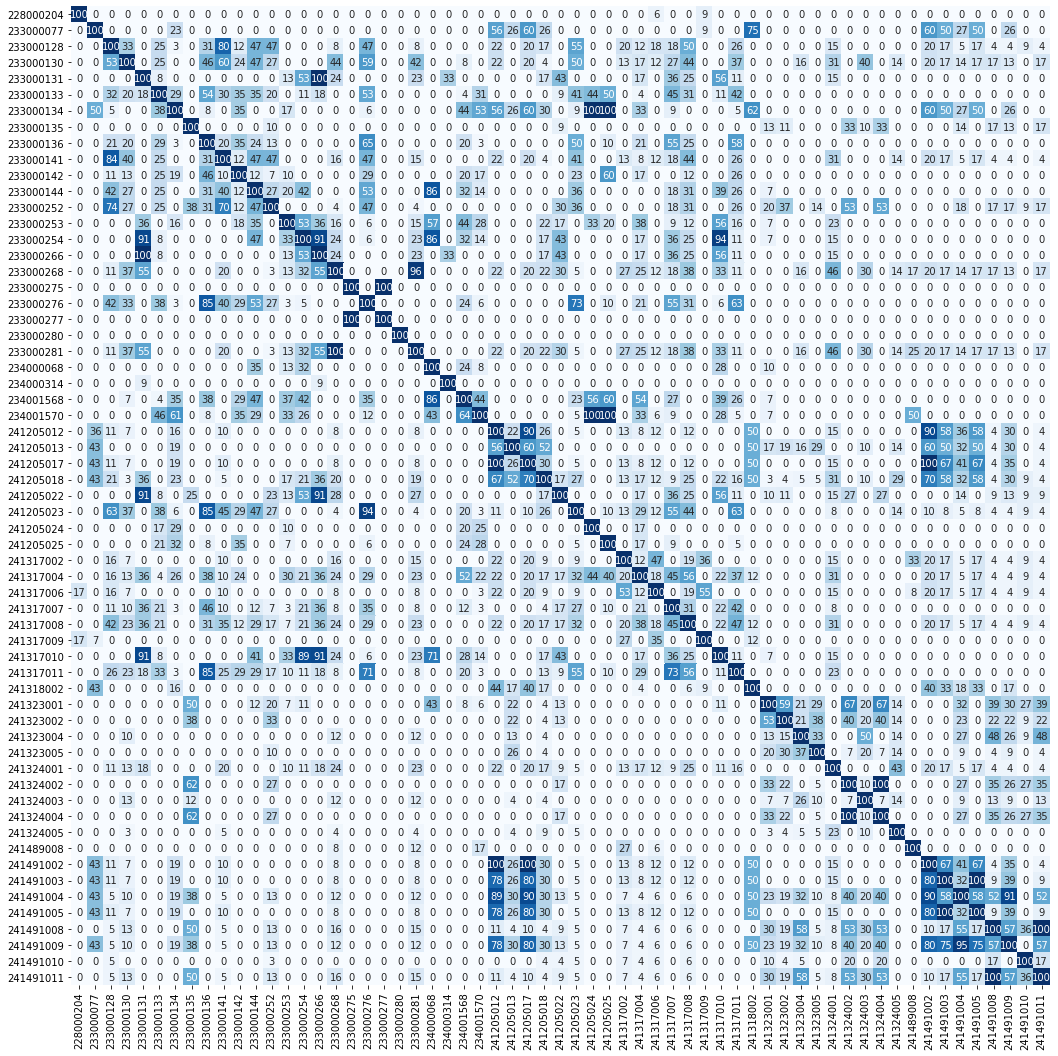

In [11]:
#히트뱁
plt.figure(figsize=(18,18))
sns.heatmap(df_redundancy, square=True, annot=True, fmt = '.0f', cmap = "Blues", cbar=False, vmin=0, vmax=100)
plt.show()

In [12]:
redundancy_flat = df_redundancy.values.flatten()
redundancy_flat = [i for i in redundancy_flat if i != 100]

In [13]:
pd.Series(redundancy_flat).describe()

count    3641.000000
mean        8.216047
std        16.088612
min         0.000000
25%         0.000000
50%         0.000000
75%        10.000000
max        96.153846
dtype: float64

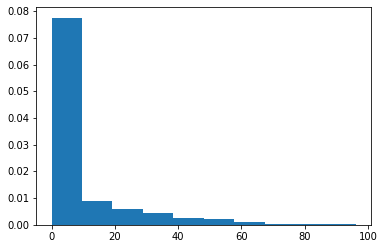

In [14]:
#분포 파악을 위한 히스토그램
plt.hist(redundancy_flat, density=True)
plt.savefig("lulu.png", dpi=300)

In [15]:
#중복도가 90% 넘는 쌍
topn_pair = {}
for route_id1, others in diff_routes.items():
    for route_id2, redundancy in others.items():
        if route_id1 == route_id2:
            continue
        if redundancy >= 0.9 and (topn_pair.get((route_id2, route_id1), None) == None):
            topn_pair[(route_id1, route_id2)] = redundancy

In [16]:
topn_pair

{(233000131, 233000254): 0.9090909090909091,
 (233000131, 233000266): 1.0,
 (233000131, 241205022): 0.9090909090909091,
 (233000131, 241317010): 0.9090909090909091,
 (233000266, 233000254): 0.9090909090909091,
 (233000266, 241205022): 0.9090909090909091,
 (233000266, 241317010): 0.9090909090909091,
 (233000268, 233000281): 1.0,
 (233000275, 233000277): 1.0,
 (233000276, 241205023): 0.9411764705882353,
 (241205012, 241205017): 1.0,
 (241205012, 241491002): 1.0,
 (241205017, 241491002): 1.0,
 (241205017, 241491004): 0.9,
 (241205024, 233000134): 1.0,
 (241205024, 234001570): 1.0,
 (241205025, 233000134): 1.0,
 (241205025, 234001570): 1.0,
 (241317010, 233000254): 0.9444444444444444,
 (241324002, 241324004): 1.0,
 (241491002, 241491004): 0.9,
 (241491003, 241491005): 1.0,
 (241491004, 241491009): 0.9545454545454546,
 (241491008, 241491011): 1.0}